In [1]:
import matplotlib.pyplot as plt
from Objects.Simulation import Simulation
import numpy as np
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib import lines, markers
from cycler import cycler

# Create cycler object. Use any styling from above you please
monochromeWithMarker = monochrome = (cycler('color', ['k']) * cycler('linestyle', ['-', '--', ':', '-.']) * cycler('marker', [ '.' ,'^']))
monochromeNoMarker = (cycler('color', ['k']) * cycler('linestyle', ['-', '--', ':', '-.']) * cycler('marker', [',']))
monochrome = monochromeNoMarker.concat(monochromeWithMarker)
# Print examples of output from cycler object. 
# A cycler object, when called, returns a `iter.cycle` object that iterates over items indefinitely
print("number of items in monochrome:", len(monochrome))
# Overriding styles for current script
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.prop_cycle'] = monochrome
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['figure.figsize'] = (12,5)
mpl.rcParams['figure.dpi']= 300
MARKEREVERY = 50

number of items in monochrome: 12


In [3]:
maxAcc = [1.34, -1.34]

In [4]:
def plot_one_key(x_timeline, ydata, key, keys):
    if len(keys) <=5:
        plt.plot(x_timeline, ydata , label = str(key+1), markevery=MARKEREVERY)
    else:
        plt.plot(x_timeline, ydata, markevery=MARKEREVERY)

In [5]:
def plot_one_record(record_zipped, dimension, x_timeline, startend = [], legend=True):
    keys = record_zipped.keys()
    if startend:
        start_filter = ((x_timeline >= startend[0]) & (x_timeline <= startend[1]))
        x_timeline = x_timeline[start_filter]
    else:
        start_filter = np.full(x_timeline.shape ,True, dtype=bool) 
    for key in keys:
        ydata = record_zipped[key][dimension]
        ydata = ydata[start_filter]
        plot_one_key(x_timeline, ydata, key ,keys)
    if legend:
        plt.legend(title="Vehicle Sequence in Queue")
    ylabelmap = {
        0:r"Acceleration - " + r"$\alpha(m/s^{2})$",
        1:r"Speed - " + r"$\nu  (m/s)$",
        2:r"Distance to the Initial Start Line - " + "$\chi(meter)$",
        3:r"Headway - H(second)"
    }
    ylabel = ylabelmap[dimension]
    plt.ylabel(ylabel)
    plt.xlabel("Time (second)")


In [6]:
def zip_records(records):
    record_zipped = {}
    for key in records.keys():
        record_zipped[key] = np.array(list(zip(*records[key].values())))
    return record_zipped

In [7]:
def plot_records(p):
    records = p.records
    x_timeline = np.array(list(records[0].keys()))
    x_timeline = x_timeline / 1000
    record_zipped = zip_records(records)
    plot_one_record(record_zipped, 0, x_timeline)
    plt.show()
    plot_one_record(record_zipped, 1, x_timeline)
    plt.show()
    plot_one_record(record_zipped, 2, x_timeline)
    plt.show()
    plot_one_record(record_zipped, 3, x_timeline)
    plt.show()

def plot_two_subplots(p1,p2, startend=[], filename = None):
    
    r1 = p1[0].records
    r2 = p2[0].records
    xt1 = np.array(list(r1[0].keys()))/1000
    xt2 = np.array(list(r2[0].keys()))/1000
    rz1 = zip_records(r1)
    rz2 = zip_records(r2)
    plt.subplot(121)
    plot_one_record(rz1, p1[1], xt1, startend, legend=False)
    plt.subplot(122)
    plot_one_record(rz2, p2[1], xt2, startend, legend=False)
    plt.legend(title="Vehicle Sequence in Queue")
    if filename:
        plt.savefig('./pics/' + filename + '.png', dpi = 300)
    plt.show()

def plot_three_subplots(p1,p2,p3, startend=[], filename = None):
    r1 = p1[0].records
    r2 = p2[0].records
    r3 = p3[0].records
    xt1 = np.array(list(r1[0].keys()))/1000
    xt2 = np.array(list(r2[0].keys()))/1000
    xt3 = np.array(list(r3[0].keys()))/1000
    rz1 = zip_records(r1)
    rz2 = zip_records(r2)
    rz3 = zip_records(r3)
    plt.subplot(131)
    plot_one_record(rz1, p1[1], xt1, startend, legend=False)
    plt.subplot(132)
    plot_one_record(rz2, p2[1], xt2, startend, legend=False)
    plt.subplot(133)
    plot_one_record(rz3, p3[1], xt3, startend, legend=False)
    plt.legend(title="Vehicle Sequence in Queue")
    if filename:
        plt.savefig('./pics/' + filename + '.png', dpi = 300)
    plt.show()

def cal_avg_delay(p):
    delays = []
    for car in p.platoon:
        if car.delay <0:
            raise Exception("Vehicle hasn't pass loc = 0 point.")
        delays.append(car.delay)
    return np.mean(delays), np.max(delays)

In [8]:
def cal_avg_avg_delay(times, number_vehicles, intended_speed):
    delays = []
    highest_delays = []
    for i in range(times):
        p = sim.run_gipps_simluation(n = number_vehicles, intend_speed = intended_speed, randomness = True)
        delays.append(cal_avg_delay(p)[0])
        highest_delays.append(cal_avg_delay(p)[1])
    return np.mean(delays), np.max(highest_delays)

In [17]:
simulation_time = 100 # seconds
number_vehicles =5 # number of vehicles
intended_speed = 22.2222 # intended speed / speed limit of the road
sim = Simulation(time = simulation_time, avStep = 500)

LRT = [1.34, -1.34]
HSR = [0.58, -0.54]

acda = sim.run_cav_simluation(n = number_vehicles, intend_speed = intended_speed, ACDA=True, maxAcc=LRT)
print("Average delay is {}, the highest delay is {}".format(*cal_avg_delay(acda)))

cav = sim.run_cav_simluation(n = number_vehicles, intend_speed = intended_speed, ACDA=False, maxAcc=LRT)
print("Average delay is {}, the highest delay is {}".format(*cal_avg_delay(cav)))

randomness = False # Gipps Model randomness
gipps = sim.run_gipps_simluation(n = number_vehicles, intend_speed = intended_speed, randomness = randomness)
print("Average delay is {}, the highest delay is {}".format(*cal_avg_delay(gipps)))

Average delay is 15.987761853420306, the highest delay is 21.648046398022757
Average delay is 8.328500328499999, the highest delay is 8.328500328499999
Average delay is 9.085075857218206, the highest delay is 9.479191143212176


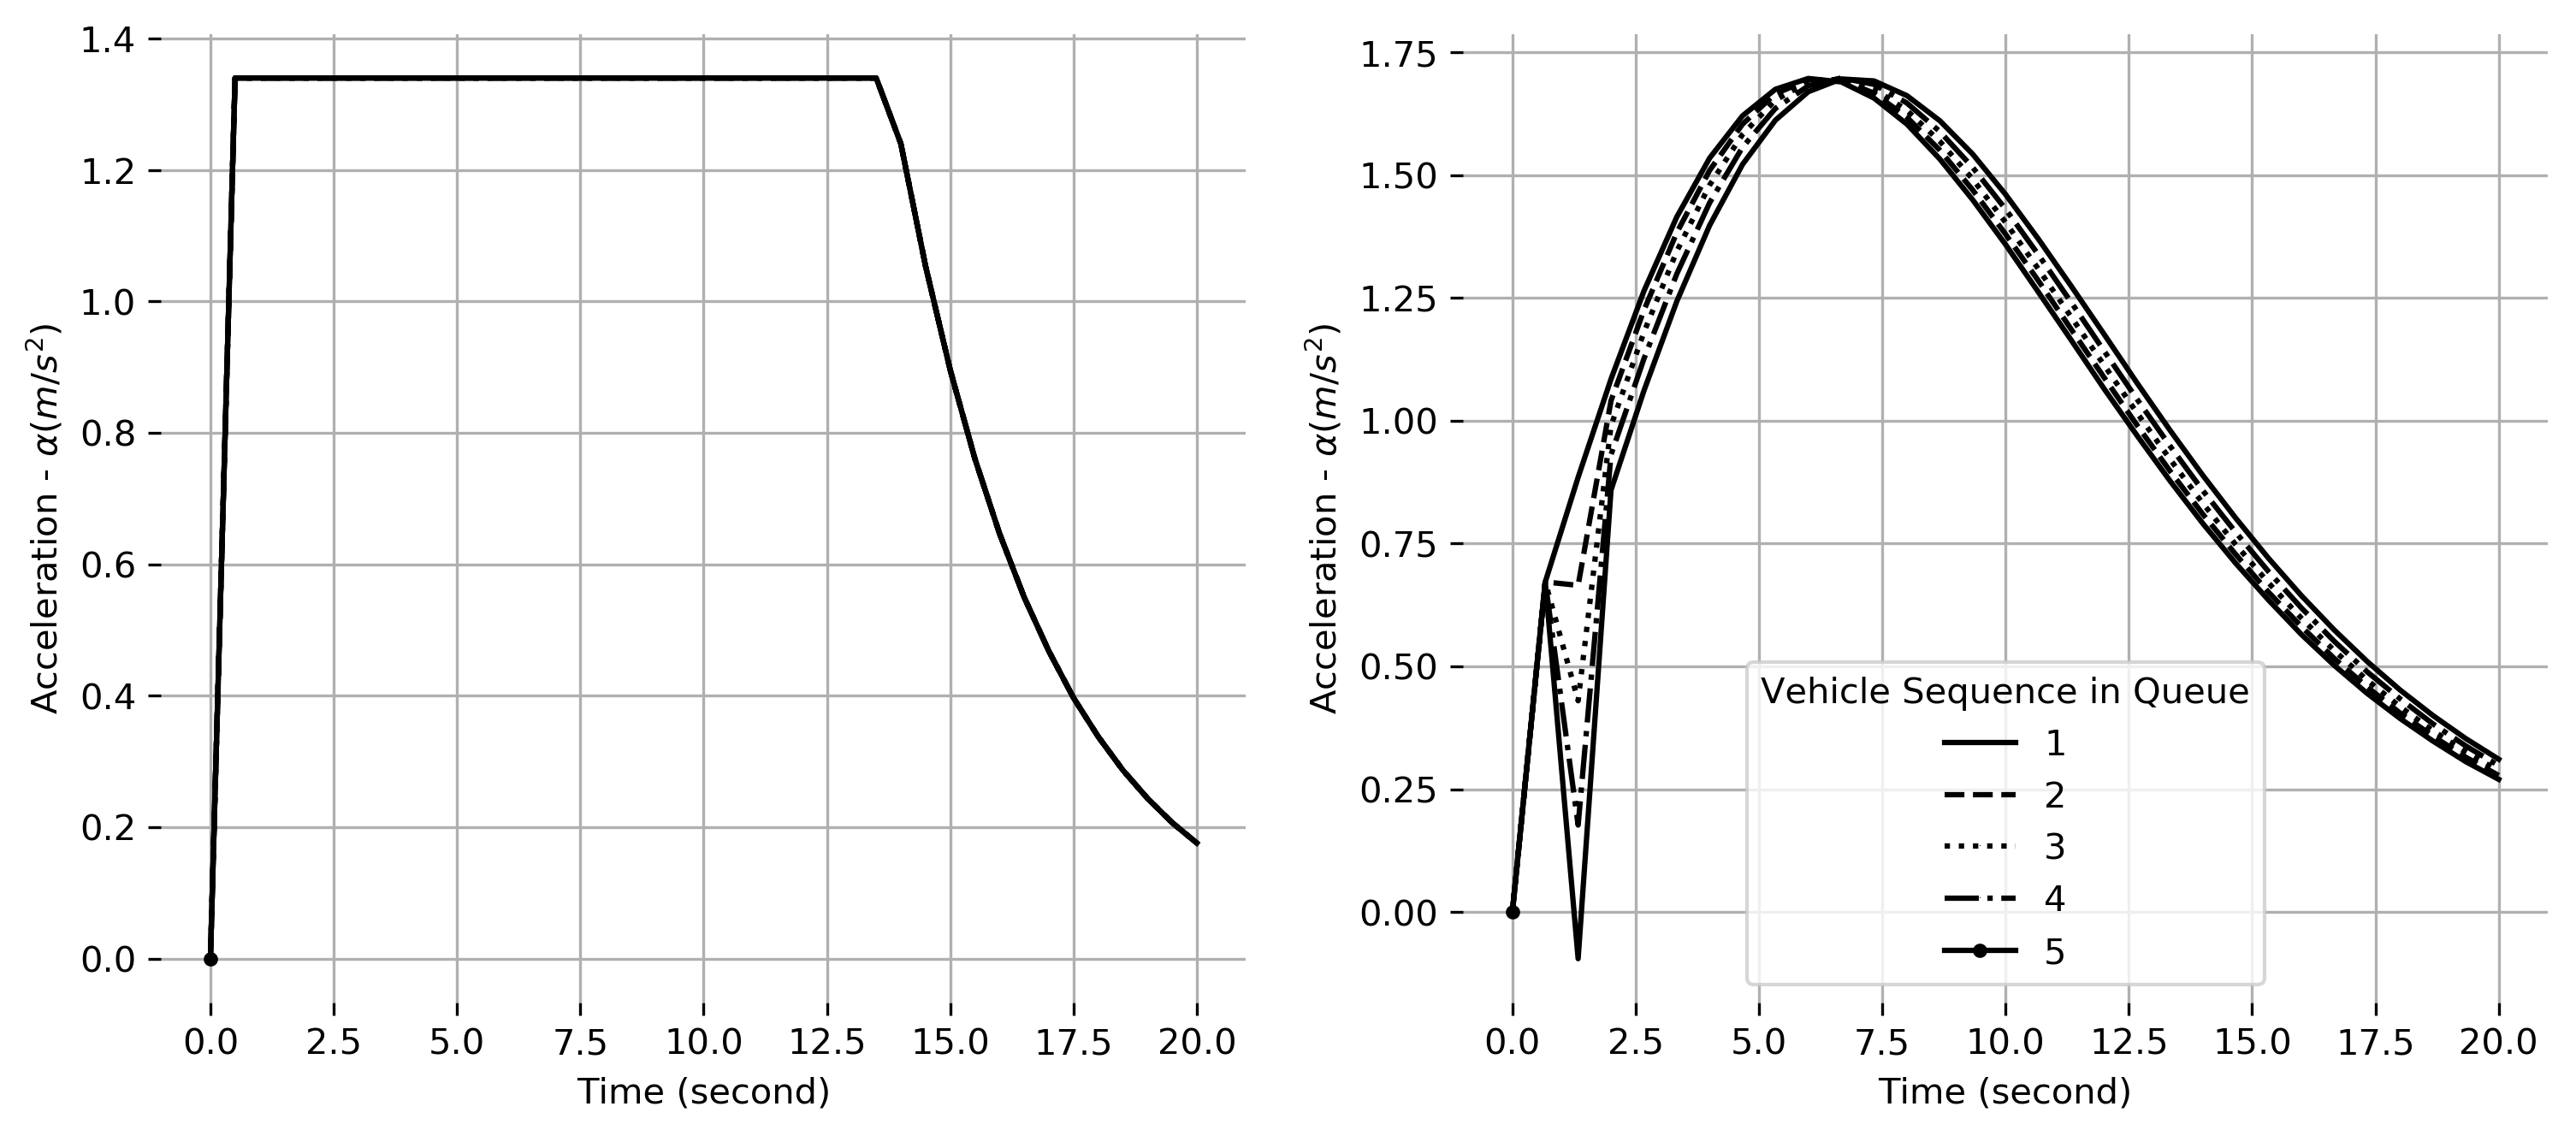

In [10]:
dim = 0
plot_two_subplots([cav, dim], [gipps, dim], startend = [0,20])

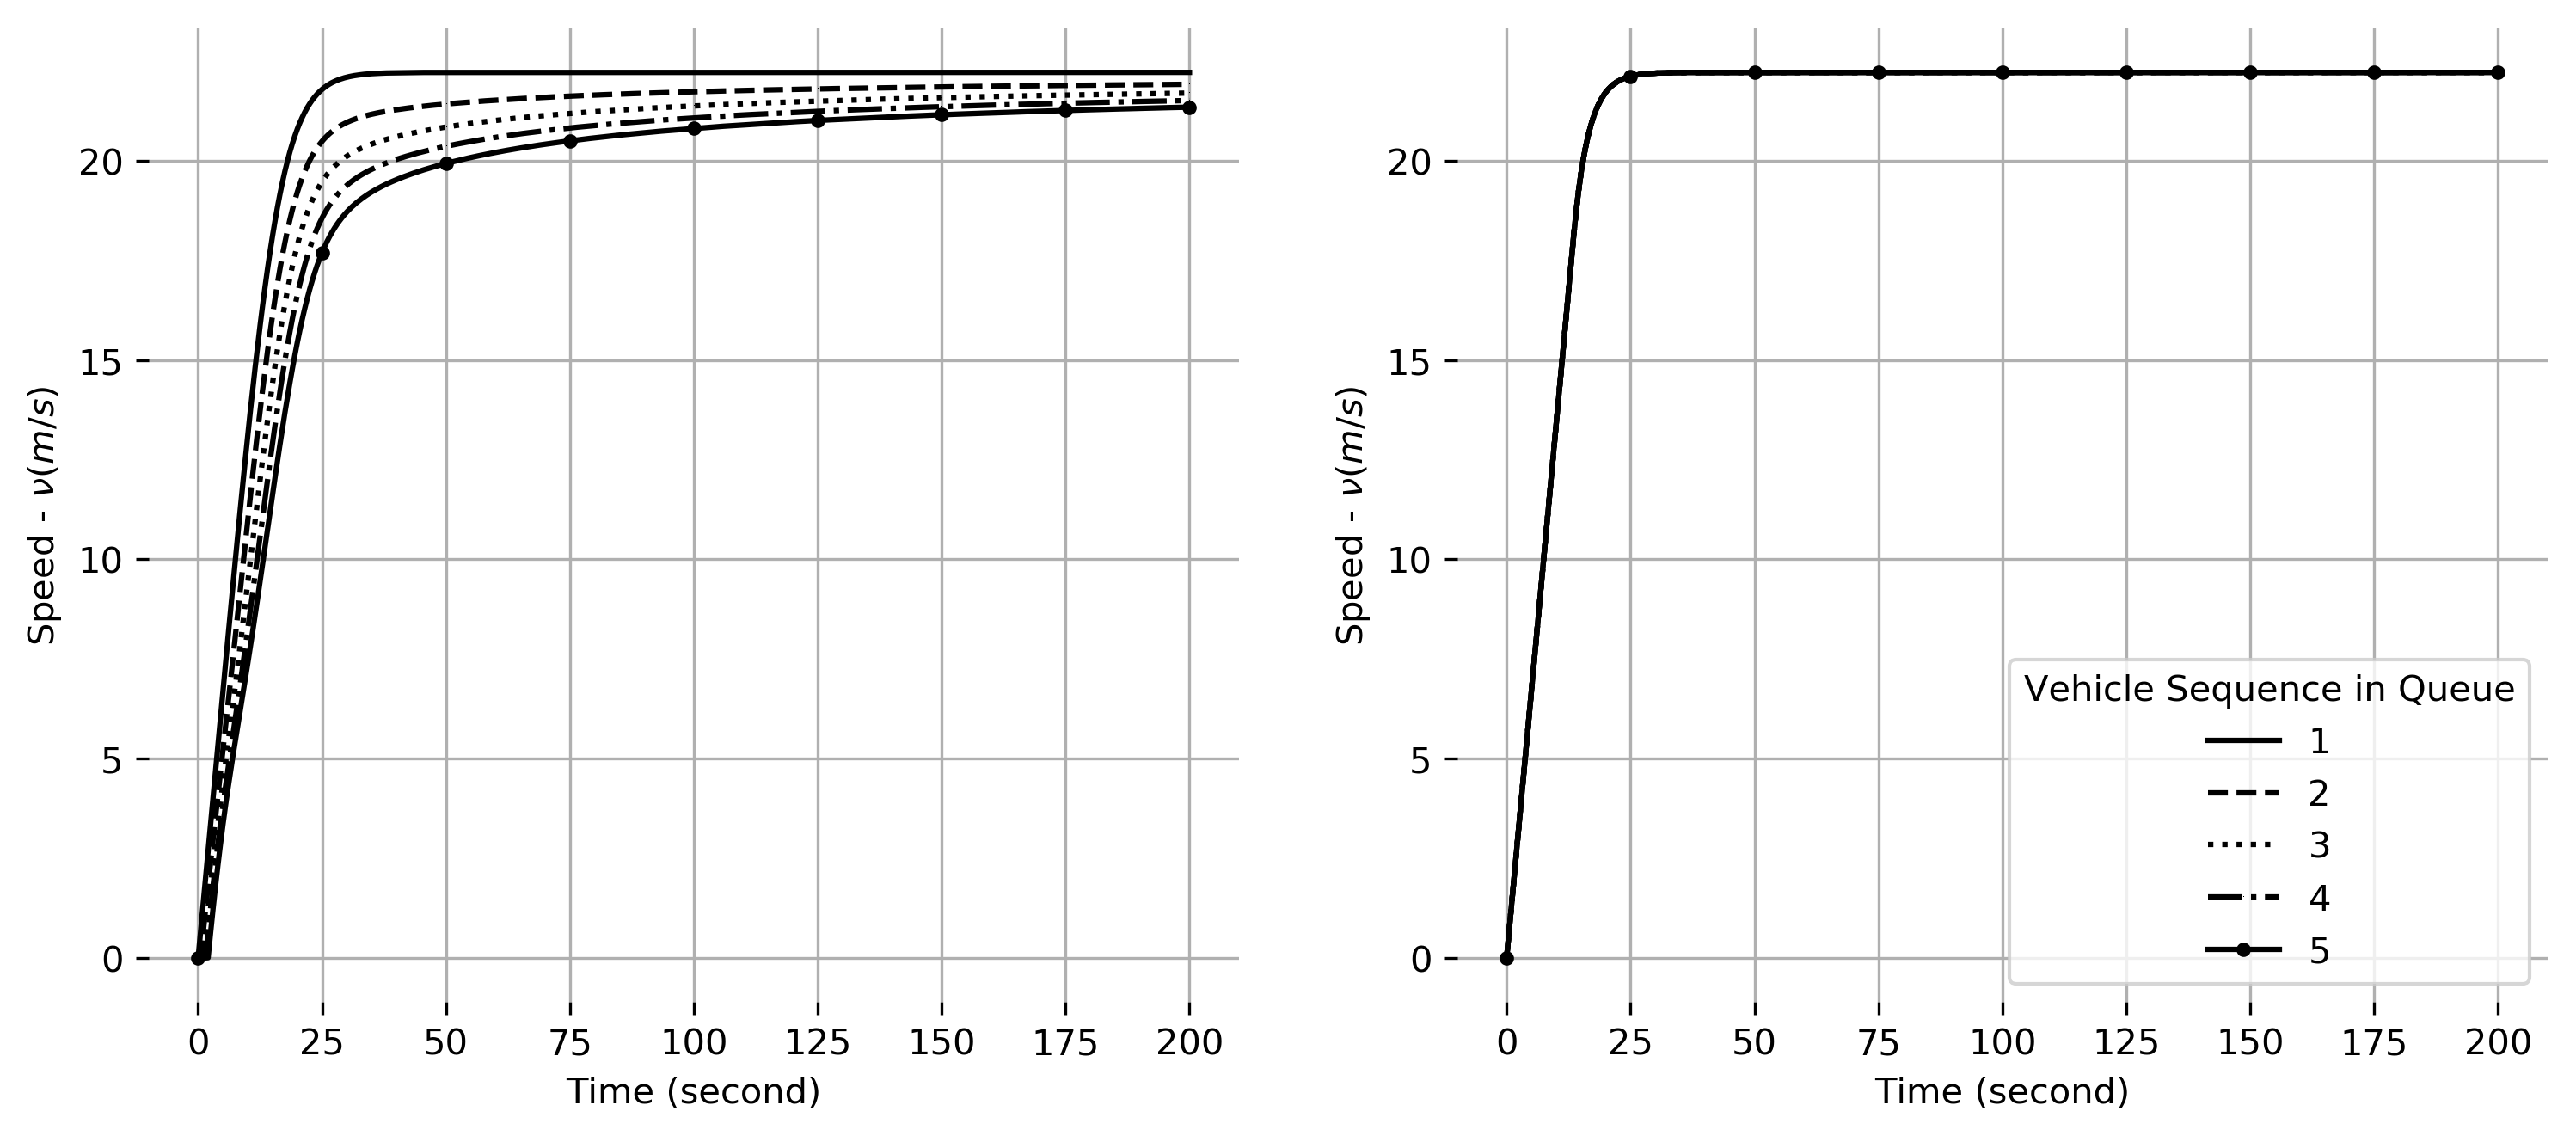

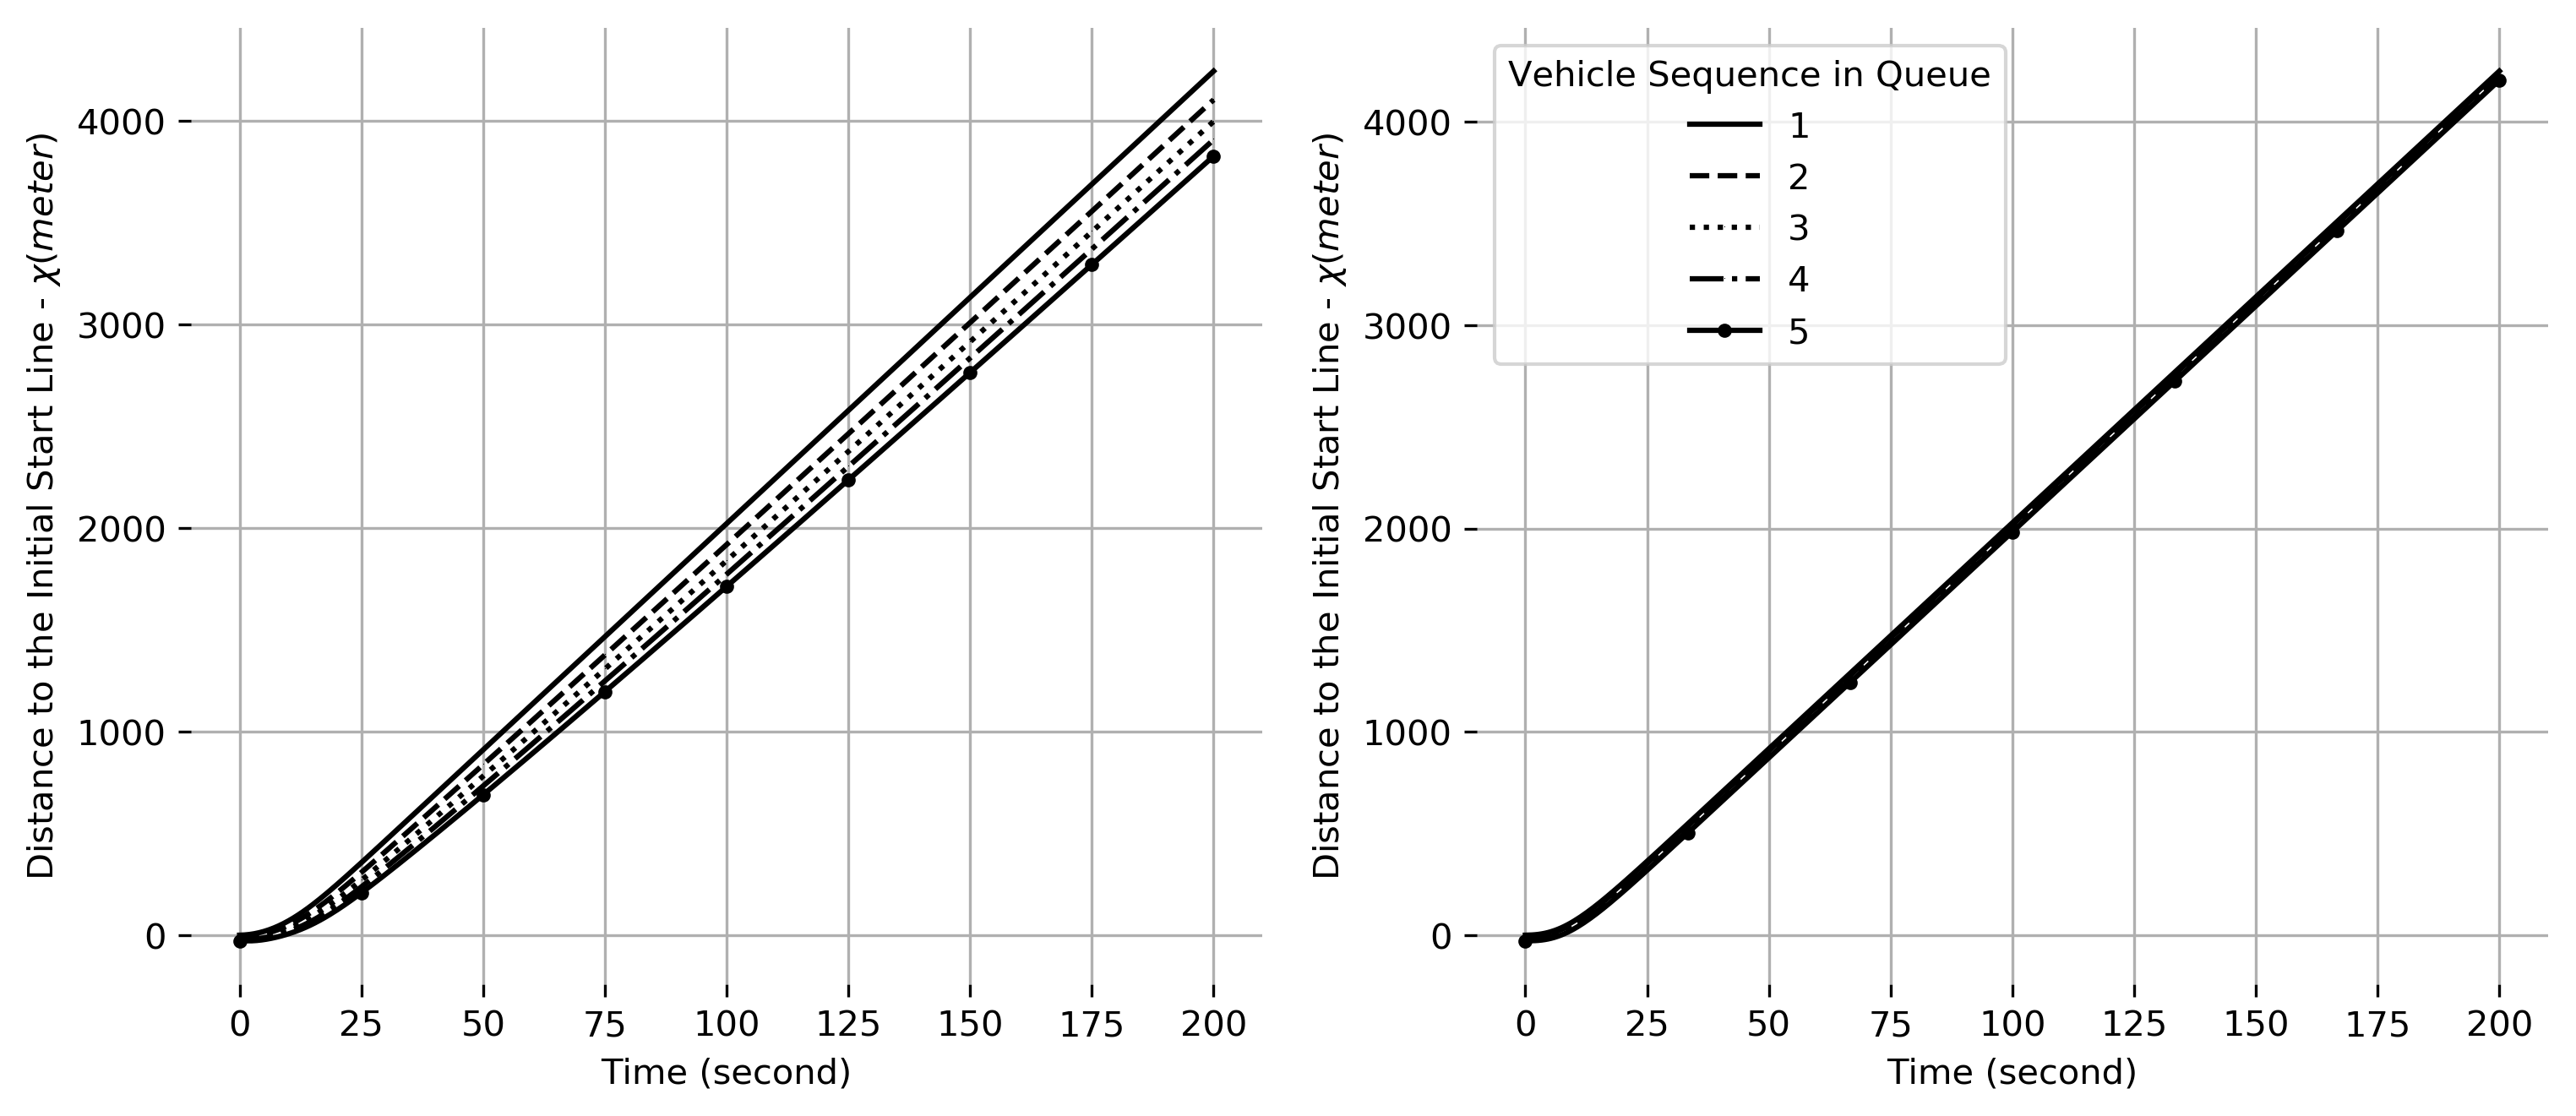

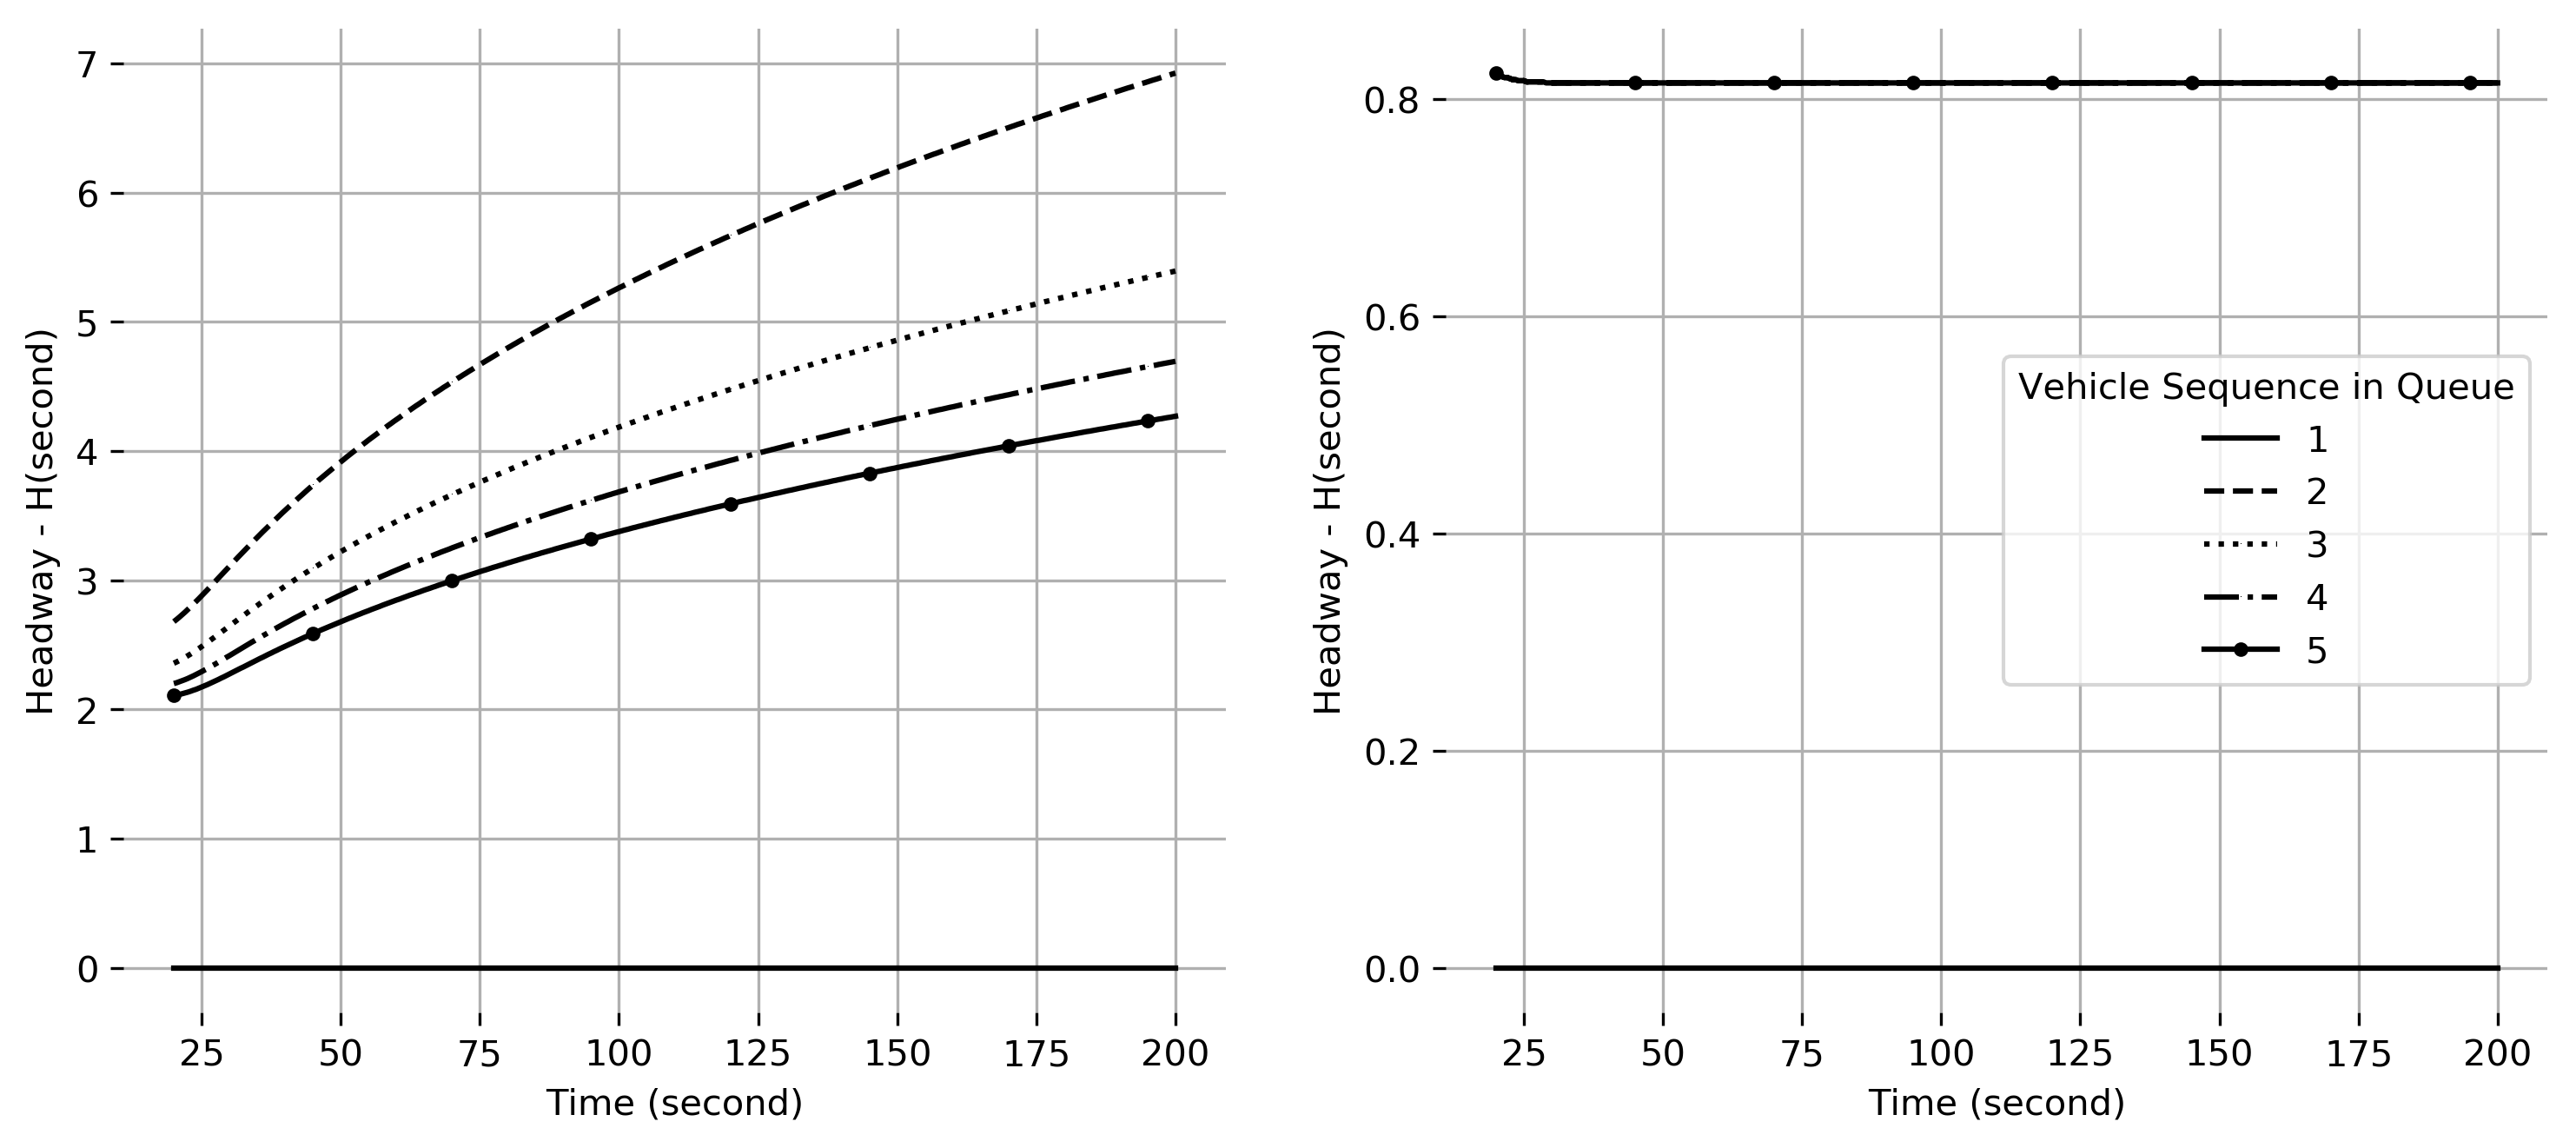

In [11]:
dim = 1
plot_two_subplots([acda,dim], [cav, dim], startend = [0,200])
dim = 2
plot_two_subplots([acda, dim], [gipps, dim], startend = [0,200])
dim = 3
plot_two_subplots([acda, dim], [cav, dim], startend = [20,200])

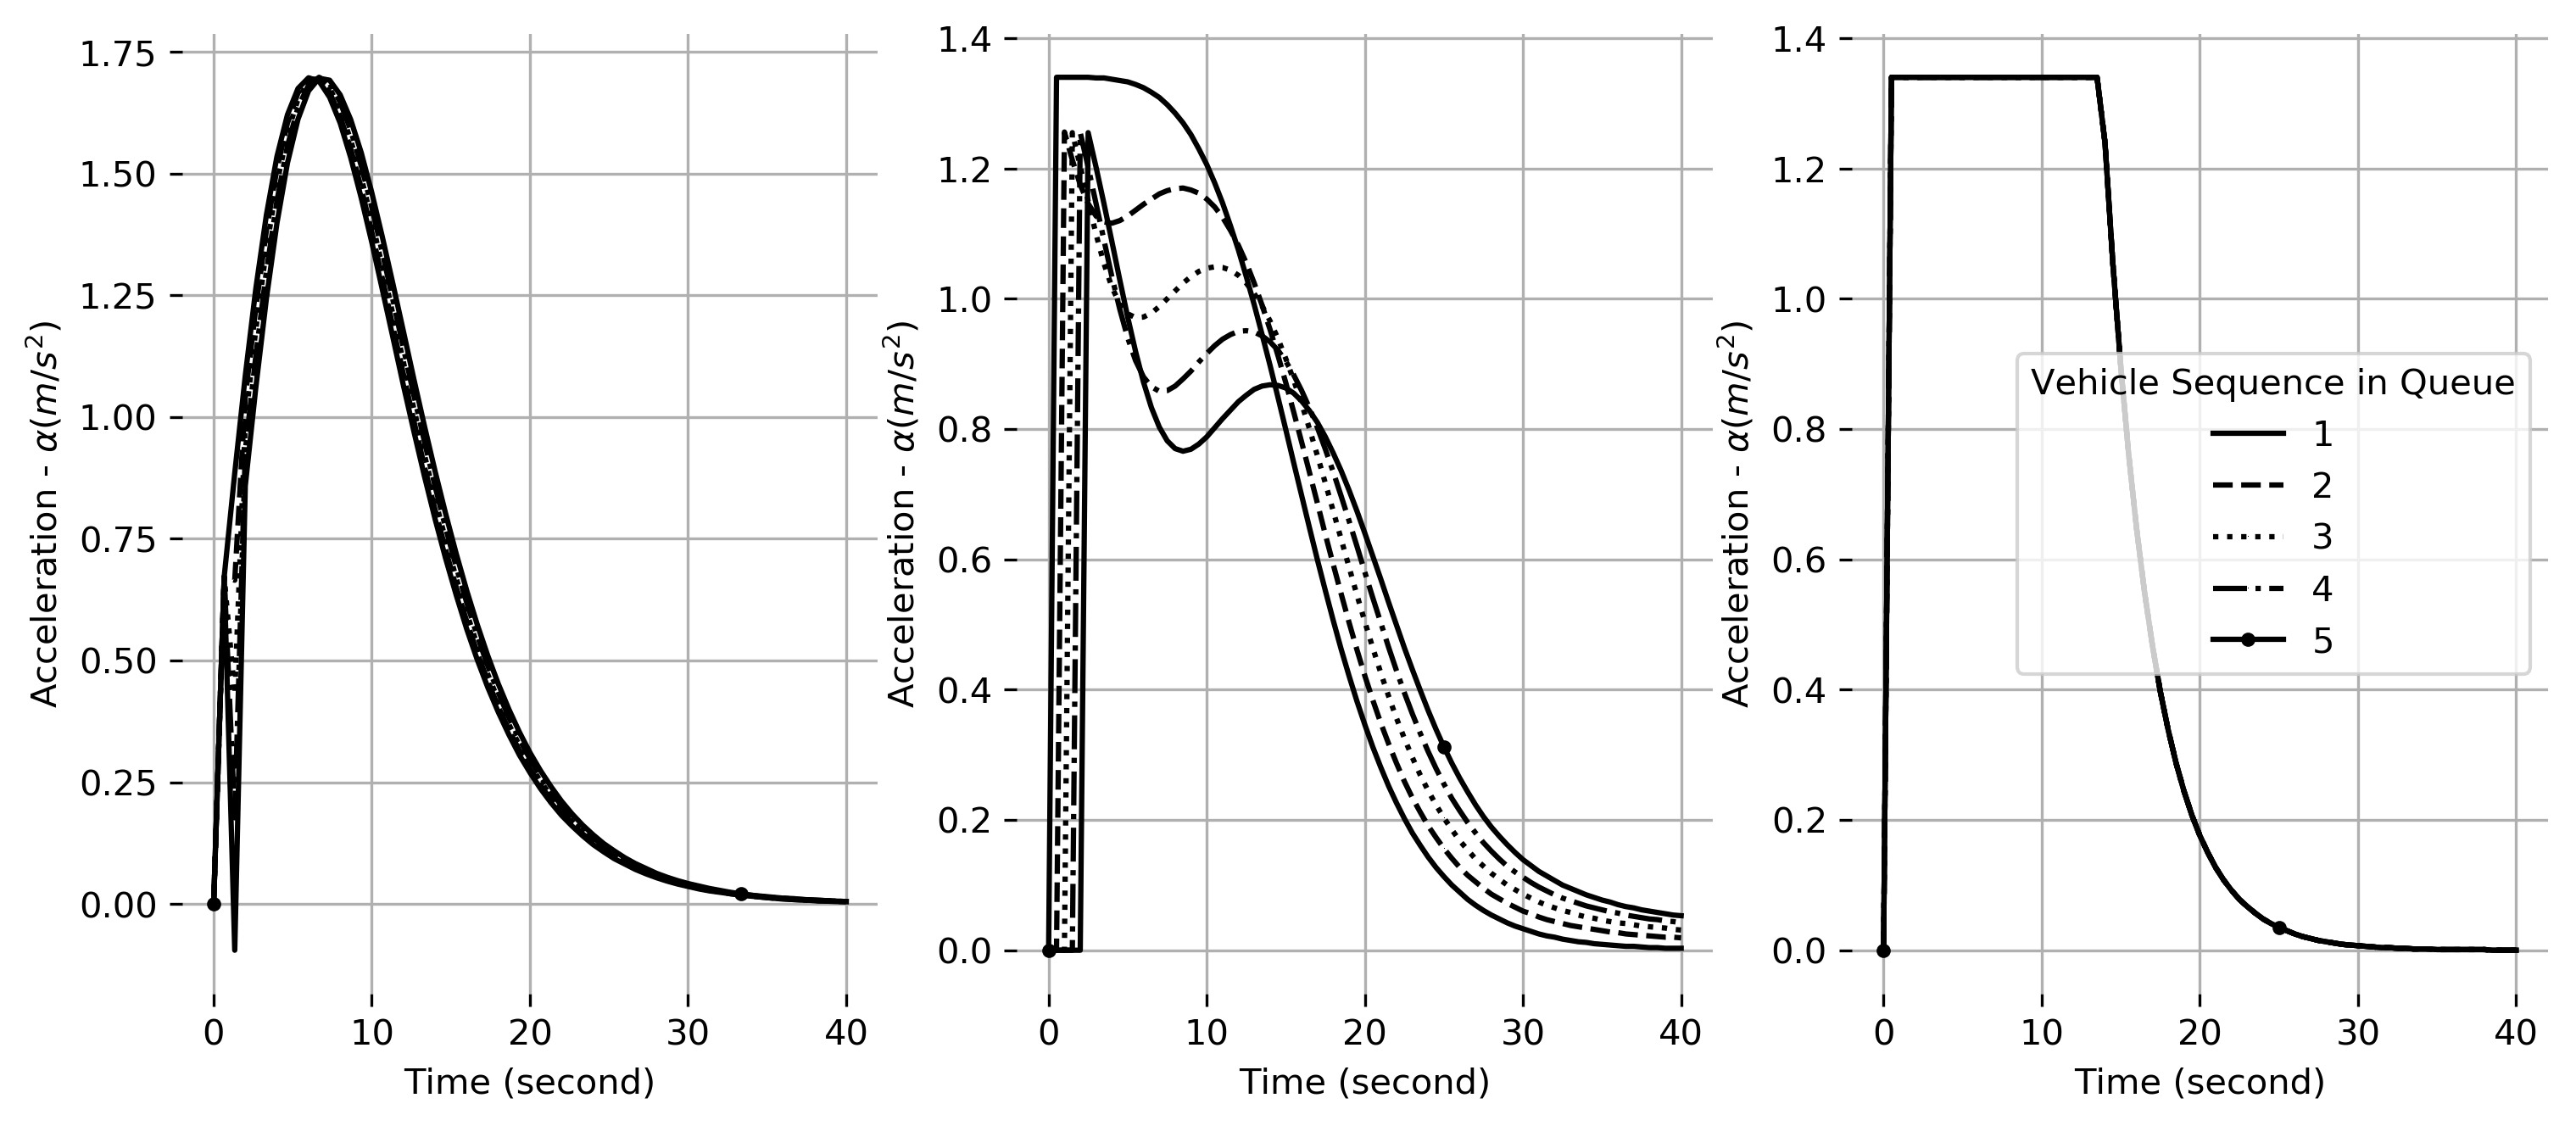

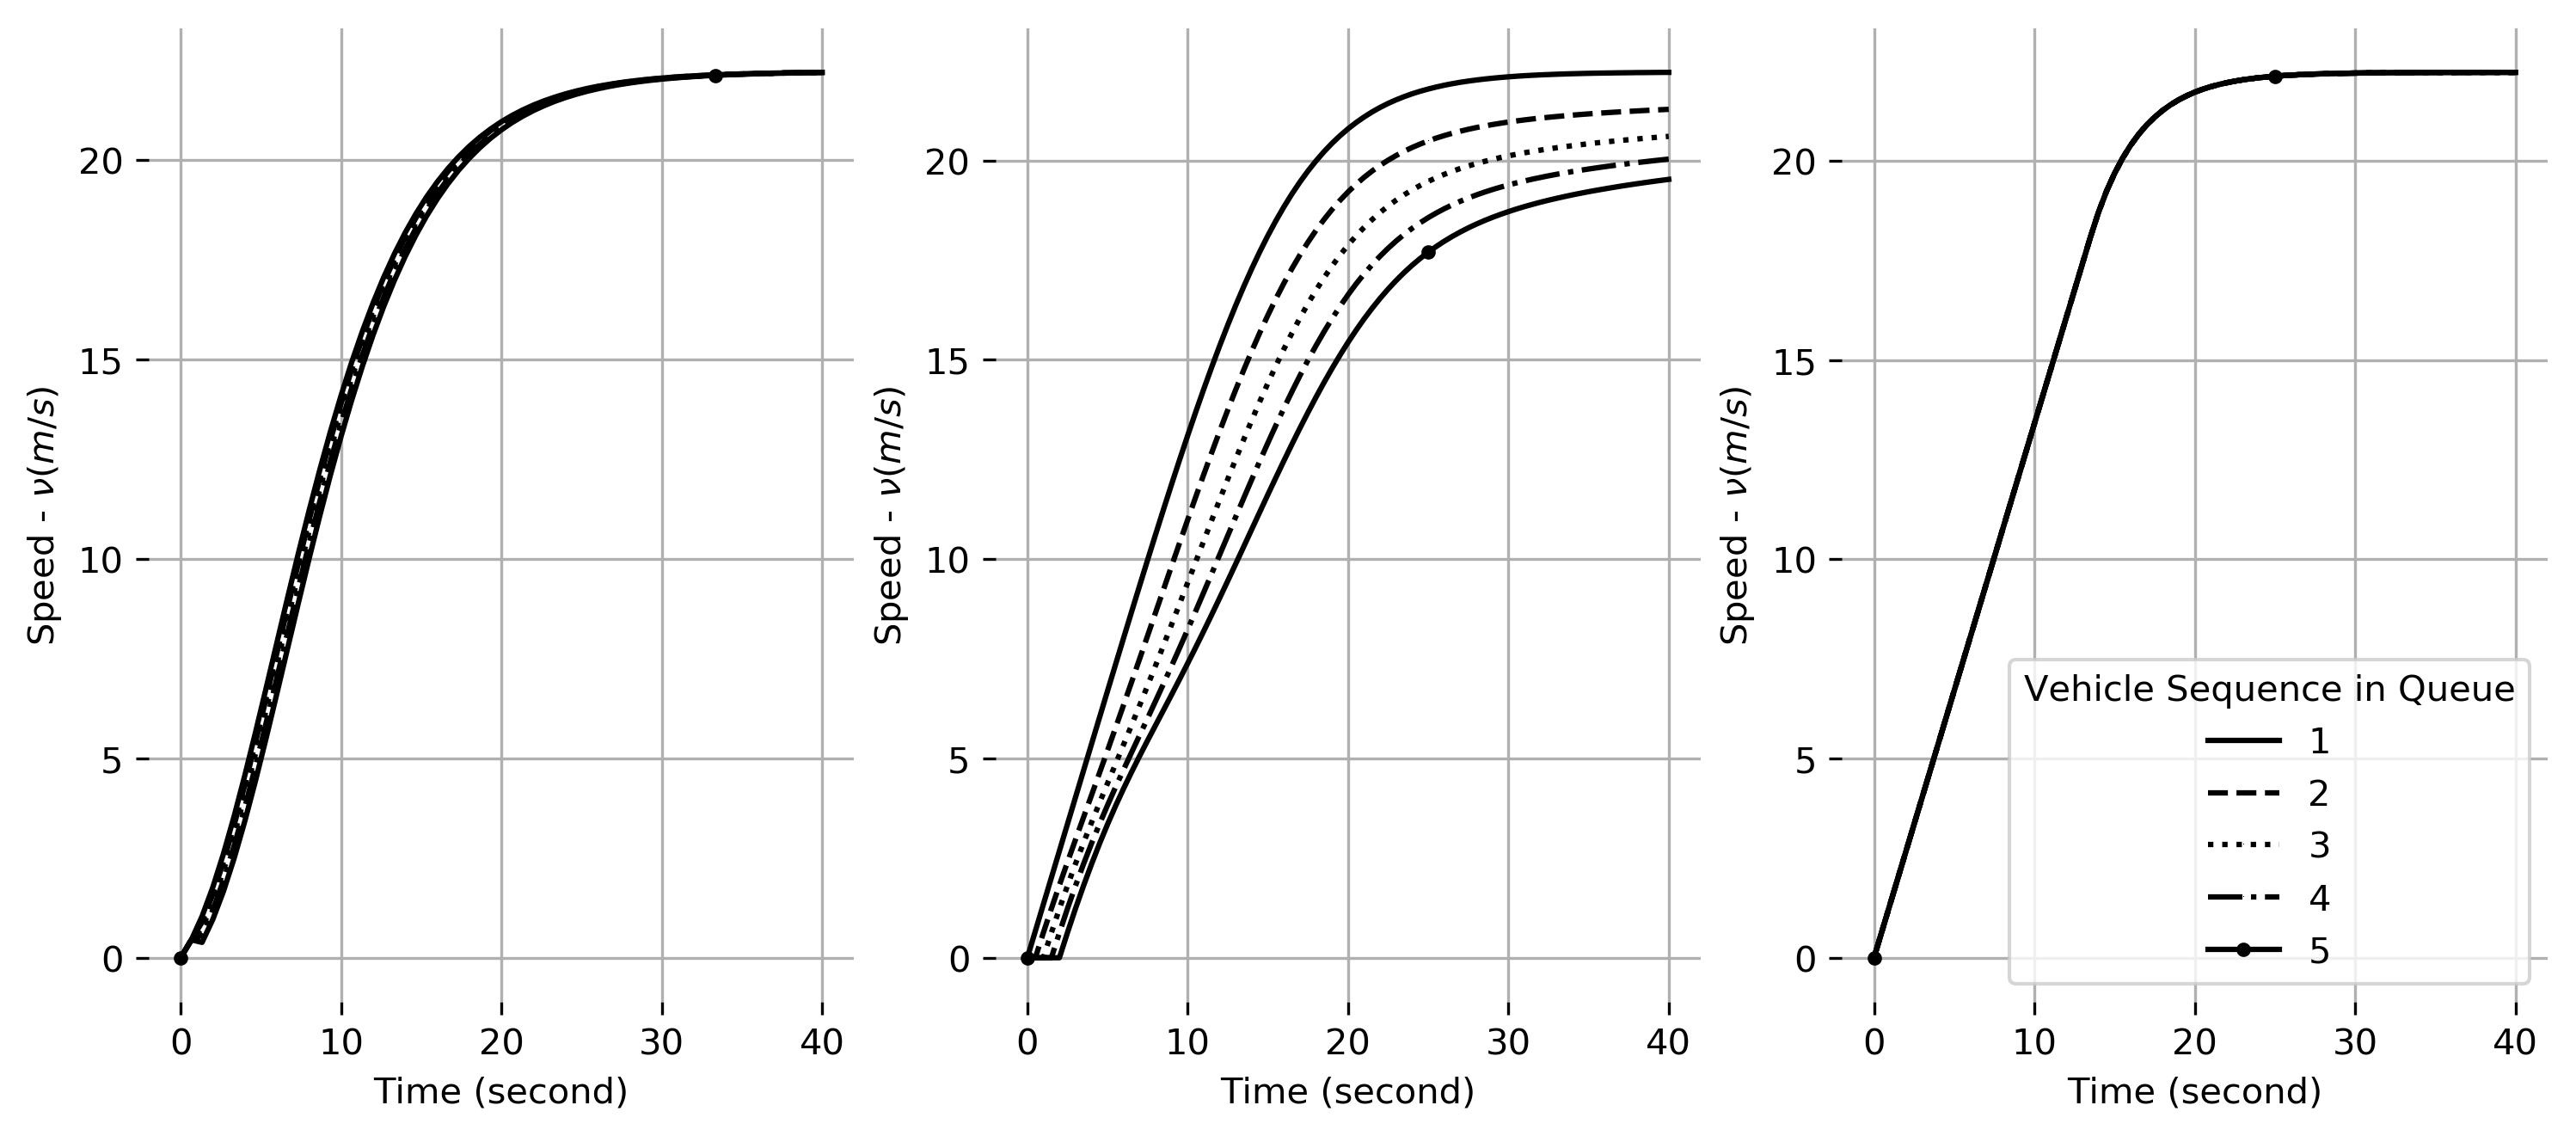

In [12]:
dim = 0
plot_three_subplots([gipps, dim], [acda, dim], [cav, dim],startend=[0,40])
dim = 1
plot_three_subplots([gipps, dim], [acda, dim], [cav, dim],startend=[0,40])